## Descripción

## Importando librerías

In [647]:
import pandas as pd

from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

## Cargando datos

In [648]:
df = pd.read_csv("spending_patterns_detailed.csv")
df

,Customer ID,Category,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,CUST_0159,Groceries,Milk,1,1.28,1.28,Debit Card,Mobile App,2024-11-13
1,CUST_0017,Friend Activities,Dinner with Friends,2,74.69,149.39,Debit Card,In-store,2023-05-04
2,CUST_0094,Housing and Utilities,Water Bill,1,76.06,76.06,Digital Wallet,Mobile App,2023-12-16
3,CUST_0162,Fitness,Yoga Class,5,11.24,56.18,Cash,In-store,2024-01-28
4,CUST_0129,Gifts,Flowers,3,43.71,131.12,Debit Card,In-store,2023-07-28
...,...,...,...,...,...,...,...,...,...
9995,CUST_0072,Housing and Utilities,Water Bill,1,69.46,69.46,Debit Card,Online,2023-09-01
9996,CUST_0150,Groceries,Snacks,5,15.54,77.70,Debit Card,In-store,2024-06-27
9997,CUST_0122,Shopping,Electronics,1,732.03,732.03,Debit Card,In-store,2024-03-19
9998,CUST_0133,Transportation,Car Repair,1,107.63,107.63,Debit Card,Mobile App,2024-10-17


In [649]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer ID       10000 non-null  object 
 1   Category          10000 non-null  object 
 2   Item              10000 non-null  object 
 3   Quantity          10000 non-null  int64  
 4   Price Per Unit    10000 non-null  float64
 5   Total Spent       10000 non-null  float64
 6   Payment Method    10000 non-null  object 
 7   Location          10000 non-null  object 
 8   Transaction Date  10000 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 703.3+ KB


In [650]:
# Convertir Transaction Date a datetime
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])

In [651]:
df.describe()

,Quantity,Price Per Unit,Total Spent,Transaction Date
count,10000.000000,10000.000000,10000.000000,10000
mean,2.237200,969.957948,2534.750890,2024-01-09 00:01:00.480000
min,1.000000,1.000000,1.110000,2023-01-01 00:00:00
25%,1.000000,12.960000,25.957500,2023-07-07 00:00:00
50%,1.000000,51.860000,88.115000,2024-01-09 00:00:00
75%,3.000000,177.587500,336.375000,2024-07-11 00:00:00
max,5.000000,74246.460000,352230.760000,2025-01-13 00:00:00
std,1.481133,6104.403843,19676.741772,NaN


## EDA & Feature Engineering

Revisaremos y procesaremos la data con el objetivo de convertirla de **nivel transacción → nivel cliente** con métricas que resumen el comportamiento de los mismos.

Para ello trataremos de combinar las columnas numéricas:
- Cantidad
- Monto total

Con las columnas categóricas:
- Category
- Payment Method
- Location

Por rango temporal dado por:
- Transaction Date (by Month)

Haremos agregaciones que contemplen:
- Suma por categoría (Total & Proporción)
- Promedio por categoría (Total & Proporción)
- Mínimo por categoría
- Máximo por categoría


In [652]:
# Viendo la data por un cliente
df[df['Customer ID'] == "CUST_0159"]

,Customer ID,Category,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,CUST_0159,Groceries,Milk,1,1.28,1.28,Debit Card,Mobile App,2024-11-13
73,CUST_0159,Fitness,Personal Trainer,2,118.44,236.88,Credit Card,In-store,2023-05-23
224,CUST_0159,Hobbies,Art Supplies,1,84.40,84.40,Digital Wallet,Online,2023-11-11
691,CUST_0159,Medical/Dental,Medicine,1,310.01,310.01,Cash,Mobile App,2023-06-09
1034,CUST_0159,Medical/Dental,Doctor Visit,1,889.19,889.19,Digital Wallet,Online,2023-03-12
1231,CUST_0159,Subscriptions,Gym Membership,1,54.61,54.61,Cash,Mobile App,2023-04-27
1423,CUST_0159,Medical/Dental,Doctor Visit,1,397.49,397.49,Credit Card,Mobile App,2024-06-17
1516,CUST_0159,Shopping,Car,1,39134.70,39134.70,Debit Card,Mobile App,2024-02-27
1570,CUST_0159,Personal Hygiene,Toothpaste,3,4.25,12.76,Credit Card,Mobile App,2023-04-10
1695,CUST_0159,Housing and Utilities,Gas Bill,1,171.34,171.34,Digital Wallet,In-store,2024-06-14


In [653]:
# Analizando cardinalidad de variables categóricas
columnas_categoricas = df.select_dtypes(include=['object']).columns
for columna in columnas_categoricas:
    print(f"Cardinalidad de {columna}: {df[columna].nunique()}")

Cardinalidad de Customer ID: 200
Cardinalidad de Category: 13
Cardinalidad de Item: 48
Cardinalidad de Payment Method: 4
Cardinalidad de Location: 3


Vemos que 'Item' tiene alta cardinalidad, por lo que no es conveniente usarlo para evitar 'la maldición de la dimensionalidad'

In [654]:
# Creamos la columna Year para hacer agregaciones por año
df['Year'] = df['Transaction Date'].dt.to_period('Y').astype(str)

Crearemos una función que simplifique este proceso de agregación de forma dinámica. El siguiente docstring describe qué hace.

In [655]:
def build_categorical_aggregations(df, index_col, col_to_agg, time_col, categorical_col, agg_type='sum', as_percentage=False):
    """
    Construye agregaciones estadísticas a nivel de cliente (u otro índice) por categoría y periodo de tiempo,
    generando características donde cada columna representa la agregación de un valor numérico por categoría.

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame original con los datos transaccionales.
    index_col : str
        Nombre de la columna que identifica a cada cliente o unidad de análisis (ejemplo: 'Customer ID').
    col_to_agg : str
        Nombre de la columna numérica sobre la cual se hará la agregación (ejemplo: 'Total Spent').
    time_col : str
        Nombre de la columna que indica el periodo de tiempo (ejemplo: 'YearMonth', debe ser tipo string o categórico).
    categorical_col : str
        Nombre de la columna categórica por la cual se segmenta la agregación (ejemplo: 'Category').
    agg_type : str, opcional, por defecto 'sum'
        Tipo de agregación a aplicar, puede ser 'sum', 'mean', 'max', 'min', etc.
    as_percentage : bool, opcional, por defecto False
        Si es True, convierte los valores agregados en proporciones (%) respecto al total por fila.

    Retorna:
    --------
    pandas.DataFrame
        DataFrame con una fila por cliente (index_col) y columnas con la agregación por cada categoría, opcionalmente normalizado a porcentaje.
        Los nombres de columnas tienen el formato: "{agg_type}_{time_col}_{col_to_agg}_{categoria}".


    """
    # Get all unique values
    all_customers = df[index_col].unique()
    all_months = df[time_col].unique()
    all_categories = df[categorical_col].unique()

    # Create full index: Customer ID x YearMonth x Category
    full_index = pd.MultiIndex.from_product(
        [all_customers, all_months, all_categories],
        names=[index_col, time_col, categorical_col]
    )

    # Aggregate total spent per customer per month per category
    monthly_spent = (
        df.groupby([index_col, time_col, categorical_col])[col_to_agg]
        .sum()
        .reindex(full_index, fill_value=0)  # Fill missing months/categories with 0
        .reset_index()
    )

    # Pivot so each category becomes a column
    pivoted = monthly_spent.pivot_table(index=[index_col, time_col],
                                        columns=categorical_col,
                                        values=col_to_agg,
                                        fill_value=0).reset_index()

    # Now calculate the average monthly spend per category per customer
    avg_monthly_spent = (
        monthly_spent.groupby([index_col, categorical_col])[col_to_agg]
        .agg(agg_type)
        .reset_index()
        .rename(columns={col_to_agg: 'Agg Spend'})
    )

    # Pivot so each category becomes a column
    features = avg_monthly_spent.pivot(index=index_col,
                                      columns=categorical_col,
                                      values='Agg Spend').fillna(0)

    features = features.add_prefix(f'{agg_type}_{time_col}_{col_to_agg}_{"pct" if as_percentage else ""}_')
    features.columns.name = None

    if as_percentage:
        features = features.div(features.sum(axis=1), axis=0)

    return features


A continuación crearemos los features agregados por cliente que usaremos para clusterizar y determinar el comportamiento de los mismos. Serán los siguientes grupos de features:

- Total de cantidad de transacciones por categoría de producto. *Para capturar frecuencia*
- Total de monto de transacciones por categoría de producto. *Para capturar volumen*
- Total de monto de transacciones por categoría de producto (porcentaje). *Para capturar comportamiento y preferencia*
- Promedio de cantidad de transacciones anuales por categoría de producto.
- Promedio de monto transacciones anuales por categoría de producto.
- Promedio de cantidad de transacciones anuales por ubicación (porcentaje). *Para capturar comportamiento tradicional vs digital*
- Promedio de monto de transacciones anuales por ubicación (porcentaje).
- Promedio de cantidad de transacciones anuales por medio de pago (porcentaje). *Para capturar comportamiento tradicional vs digital*
- Promedio de monto de transacciones anuales por medio de pago (porcentaje).

In [656]:
# Ejemplo de Promedio de monto de transacciones anuales por ubicación (porcentaje).
build_categorical_aggregations(df, 'Customer ID', 'Total Spent', 'Year', 'Location', 'mean', as_percentage=True)

,mean_Year_Total Spent_pct_In-store,mean_Year_Total Spent_pct_Mobile App,mean_Year_Total Spent_pct_Online
Customer ID,,,
CUST_0001,0.239971,0.348822,0.411207
CUST_0002,0.157069,0.793460,0.049472
CUST_0003,0.130202,0.030608,0.839190
CUST_0004,0.366748,0.572563,0.060689
CUST_0005,0.349263,0.438975,0.211762
...,...,...,...
CUST_0196,0.290683,0.438653,0.270664
CUST_0197,0.103620,0.745270,0.151110
CUST_0198,0.006859,0.986277,0.006864


In [657]:
# Ejemplo de Promedio de monto de transacciones anuales en general
# Para calcular los datos en general se agrega una columna simbólica
df["General"] = "General"
build_categorical_aggregations(df, 'Customer ID', 'Total Spent', 'Year', 'General', 'mean')

,mean_Year_Total Spent__General
Customer ID,
CUST_0001,3489.603333
CUST_0002,31993.350000
CUST_0003,23600.040000
CUST_0004,11464.283333
CUST_0005,5936.010000
...,...
CUST_0196,6558.326667
CUST_0197,7400.936667
CUST_0198,84636.666667


In [658]:
# Tabla de features concatenados
df_features = pd.concat([
  build_categorical_aggregations(df, 'Customer ID', 'Quantity', 'Year', 'General', 'mean'),
  build_categorical_aggregations(df, 'Customer ID', 'Total Spent', 'Year', 'General', 'mean'),
  build_categorical_aggregations(df, 'Customer ID', 'Quantity', 'Year', 'Category', 'sum'),
  build_categorical_aggregations(df, 'Customer ID', 'Total Spent', 'Year', 'Category', 'sum', as_percentage=True),
  build_categorical_aggregations(df, 'Customer ID', 'Quantity', 'Year', 'Category', 'mean'),
  build_categorical_aggregations(df, 'Customer ID', 'Total Spent', 'Year', 'Category', 'mean'),
  build_categorical_aggregations(df, 'Customer ID', 'Quantity', 'Year', 'Location', 'mean', as_percentage=True),
  build_categorical_aggregations(df, 'Customer ID', 'Total Spent', 'Year', 'Location', 'mean', as_percentage=True),
  build_categorical_aggregations(df, 'Customer ID', 'Quantity', 'Year', 'Payment Method', 'mean', as_percentage=True),
  build_categorical_aggregations(df, 'Customer ID', 'Total Spent', 'Year', 'Payment Method', 'mean', as_percentage=True),
], axis=1)

df_features

,mean_Year_Quantity__General,mean_Year_Total Spent__General,sum_Year_Quantity__Fitness,sum_Year_Quantity__Food,sum_Year_Quantity__Friend Activities,sum_Year_Quantity__Gifts,sum_Year_Quantity__Groceries,sum_Year_Quantity__Hobbies,sum_Year_Quantity__Housing and Utilities,sum_Year_Quantity__Medical/Dental,...,mean_Year_Total Spent_pct_Mobile App,mean_Year_Total Spent_pct_Online,mean_Year_Quantity_pct_Cash,mean_Year_Quantity_pct_Credit Card,mean_Year_Quantity_pct_Debit Card,mean_Year_Quantity_pct_Digital Wallet,mean_Year_Total Spent_pct_Cash,mean_Year_Total Spent_pct_Credit Card,mean_Year_Total Spent_pct_Debit Card,mean_Year_Total Spent_pct_Digital Wallet
Customer ID,,,,,,,,,,,,,,,,,,,,,
CUST_0001,28.000000,3489.603333,9,12,11,6,4,6,2,9,...,0.348822,0.411207,0.273810,0.309524,0.285714,0.130952,0.082911,0.486710,0.356637,0.073743
CUST_0002,39.333333,31993.350000,19,10,11,7,9,24,8,2,...,0.793460,0.049472,0.254237,0.110169,0.228814,0.406780,0.019809,0.745148,0.053936,0.181107
CUST_0003,37.000000,23600.040000,10,13,12,15,11,5,4,1,...,0.030608,0.839190,0.324324,0.333333,0.144144,0.198198,0.836943,0.041572,0.020096,0.101389
CUST_0004,37.666667,11464.283333,15,12,8,17,10,15,8,6,...,0.572563,0.060689,0.159292,0.283186,0.292035,0.265487,0.019683,0.320238,0.516712,0.143367
CUST_0005,38.000000,5936.010000,8,15,1,10,19,7,0,6,...,0.438975,0.211762,0.377193,0.184211,0.254386,0.184211,0.368233,0.308346,0.250262,0.073158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CUST_0196,36.000000,6558.326667,19,7,19,1,9,13,6,3,...,0.438653,0.270664,0.222222,0.231481,0.296296,0.250000,0.089610,0.275825,0.419832,0.214733
CUST_0197,41.666667,7400.936667,17,24,6,16,17,8,2,4,...,0.745270,0.151110,0.224000,0.416000,0.160000,0.200000,0.041871,0.113067,0.148409,0.696653
CUST_0198,30.000000,84636.666667,20,11,6,15,8,4,1,2,...,0.986277,0.006864,0.255556,0.200000,0.211111,0.333333,0.977888,0.004630,0.002748,0.014734


In [659]:
df_features.describe()

,mean_Year_Quantity__General,mean_Year_Total Spent__General,sum_Year_Quantity__Fitness,sum_Year_Quantity__Food,sum_Year_Quantity__Friend Activities,sum_Year_Quantity__Gifts,sum_Year_Quantity__Groceries,sum_Year_Quantity__Hobbies,sum_Year_Quantity__Housing and Utilities,sum_Year_Quantity__Medical/Dental,...,mean_Year_Total Spent_pct_Mobile App,mean_Year_Total Spent_pct_Online,mean_Year_Quantity_pct_Cash,mean_Year_Quantity_pct_Credit Card,mean_Year_Quantity_pct_Debit Card,mean_Year_Quantity_pct_Digital Wallet,mean_Year_Total Spent_pct_Cash,mean_Year_Total Spent_pct_Credit Card,mean_Year_Total Spent_pct_Debit Card,mean_Year_Total Spent_pct_Digital Wallet
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,37.286667,42245.848167,12.135000,11.775000,11.480000,11.820000,12.050000,10.655000,3.820000,3.850000,...,0.341295,0.346552,0.246889,0.250034,0.247697,0.255380,0.245280,0.252407,0.202689,0.299625
std,6.344831,44680.694968,6.688081,6.185115,6.557025,7.465674,7.116228,6.381976,1.953633,1.935518,...,0.305602,0.316639,0.074180,0.076233,0.076341,0.073884,0.294288,0.281927,0.251755,0.303039
min,24.333333,2501.593333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002977,0.001614,0.060976,0.072917,0.079545,0.078261,0.003518,0.001685,0.002748,0.001624
25%,33.000000,6437.579167,7.000000,7.000000,6.750000,6.000000,7.000000,6.000000,2.000000,2.000000,...,0.057575,0.051417,0.195758,0.190909,0.189868,0.200000,0.029845,0.028525,0.019580,0.037048
50%,37.000000,24088.560000,12.000000,11.500000,10.000000,11.000000,11.000000,10.000000,4.000000,4.000000,...,0.270173,0.253491,0.242942,0.248201,0.239835,0.250000,0.114104,0.132157,0.102422,0.203878
75%,41.333333,67856.200000,16.250000,15.000000,16.000000,16.000000,16.000000,15.000000,5.000000,5.000000,...,0.526217,0.536063,0.287419,0.302648,0.295665,0.295809,0.324698,0.358985,0.277610,0.474314
max,64.000000,225448.900000,37.000000,35.000000,34.000000,35.000000,34.000000,32.000000,10.000000,9.000000,...,0.986277,0.987423,0.450382,0.458333,0.500000,0.510417,0.986593,0.977729,0.959721,0.983068


## Reducción de dimensionalidad

Una vez hecho esto, es recomendable reducir la dimensionalidad de los vectores que usaremos. Muchas de estas características están correlacionadas y, por lo tanto, son redundantes. Por ello, realizaré una reducción de dimensionalidad en las características seleccionadas antes de pasarlas por el clusterizador.
La reducción de dimensionalidad es el proceso de reducir el número de variables aleatorias consideradas, obteniendo un conjunto de variables principales.

**El análisis de componentes principales (PCA)** es una técnica para reducir la dimensionalidad de estos conjuntos de datos, lo que aumenta la interpretabilidad y, al mismo tiempo, minimiza la pérdida de información.

In [660]:
# Primero normalizamos la data para evitar sesgos
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
df_scaled

,mean_Year_Quantity__General,mean_Year_Total Spent__General,sum_Year_Quantity__Fitness,sum_Year_Quantity__Food,sum_Year_Quantity__Friend Activities,sum_Year_Quantity__Gifts,sum_Year_Quantity__Groceries,sum_Year_Quantity__Hobbies,sum_Year_Quantity__Housing and Utilities,sum_Year_Quantity__Medical/Dental,...,mean_Year_Total Spent_pct_Mobile App,mean_Year_Total Spent_pct_Online,mean_Year_Quantity_pct_Cash,mean_Year_Quantity_pct_Credit Card,mean_Year_Quantity_pct_Debit Card,mean_Year_Quantity_pct_Digital Wallet,mean_Year_Total Spent_pct_Cash,mean_Year_Total Spent_pct_Credit Card,mean_Year_Total Spent_pct_Debit Card,mean_Year_Total Spent_pct_Digital Wallet
0,-1.467331,-0.869581,-0.469921,0.036469,-0.073388,-0.781524,-1.134056,-0.731228,-0.933935,2.667463,...,0.024692,0.204703,0.363818,0.782326,0.499234,-1.688307,-0.553117,0.833163,0.613032,-0.747260
1,0.323382,-0.230037,1.029029,-0.287699,-0.073388,-0.647242,-0.429673,2.096292,2.144972,-0.958215,...,1.483302,-0.940587,0.099310,-1.839304,-0.247982,2.054293,-0.768077,1.752149,-0.592347,-0.392079
2,-0.045295,-0.418360,-0.320026,0.198553,0.079503,0.427018,-0.147920,-0.888313,0.092367,-1.476169,...,-1.019192,1.559739,1.046499,1.095435,-1.359855,-0.775873,2.015533,-0.749713,-0.727098,-0.655801
3,0.060042,-0.690652,0.429449,0.036469,-0.532060,0.695583,-0.288797,0.682532,2.144972,1.113601,...,0.758662,-0.905071,-1.183825,0.435966,0.582242,0.137141,-0.768507,0.241203,1.250464,-0.516930
4,0.112710,-0.814691,-0.619816,0.522722,-1.602297,-0.244394,0.979092,-0.574144,-1.960238,1.113601,...,0.320435,-0.426760,1.760991,-0.865620,0.087833,-0.965667,0.418849,0.198916,0.189442,-0.749195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.203299,-0.800728,1.029029,-0.773952,1.149740,-1.452937,-0.429673,0.368363,1.118670,-0.440261,...,0.319377,-0.240270,-0.333357,-0.243978,0.638196,-0.072993,-0.530298,0.083275,0.864680,-0.280838
196,0.692058,-0.781822,0.729239,1.981479,-0.837842,0.561301,0.697339,-0.417059,-0.933935,0.077693,...,1.325219,-0.618791,-0.309331,2.182552,-1.151637,-0.751425,-0.692922,-0.495481,-0.216148,1.313444
197,-1.151323,0.951131,1.178924,-0.125615,-0.837842,0.427018,-0.570550,-1.045397,-1.447087,-0.958215,...,2.115828,-1.075486,0.117126,-0.657978,-0.480450,1.057727,2.495672,-0.881076,-0.796182,-0.942472
198,-0.466639,0.539590,2.378083,-1.422289,-0.990733,0.427018,-0.007044,0.682532,0.092367,0.077693,...,-1.074784,-1.016845,-0.187570,-1.500638,1.337055,0.355143,-0.762822,-0.872703,-0.758919,2.183185


In [661]:
# Se hará una prueba de PCA a 3 componentes

print(f"Dimensión de los vectores antes de reducción: {df_scaled.shape[1]}")

pca = PCA(n_components=3, random_state=42)
pca.fit(df_scaled)
df_reduced = pd.DataFrame(pca.transform(df_scaled), columns=(["component 1", "component 2", "component 3"]))

print(f"Dimensión de los vectores antes de reducción: {df_reduced.shape[1]}")
df_reduced

Dimensión de los vectores antes de reducción: 68
Dimensión de los vectores antes de reducción: 3


,component 1,component 2,component 3
0,-5.824967,-4.384561,0.196454
1,0.541058,0.858729,-0.576179
2,1.621724,0.661432,-0.728904
3,-1.584824,0.884021,-2.337811
4,-2.420934,1.009923,-2.229389
...,...,...,...
195,-2.050314,-0.421581,-0.613774
196,-0.128631,1.934933,0.985849
197,2.060602,-2.426961,1.150613
198,2.239744,-1.297316,1.647777


In [662]:
df_reduced.describe()

,component 1,component 2,component 3
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,2.131628e-16,-8.881784e-17,5.329071e-17
std,2.929759e+00,2.149876e+00,2.017563e+00
min,-6.995768e+00,-4.605806e+00,-5.684890e+00
25%,-2.730003e+00,-1.686842e+00,-1.413249e+00
50%,9.236275e-01,-4.434549e-02,-1.895985e-01
75%,2.473853e+00,1.110085e+00,1.261590e+00
max,5.225145e+00,6.953648e+00,6.305866e+00


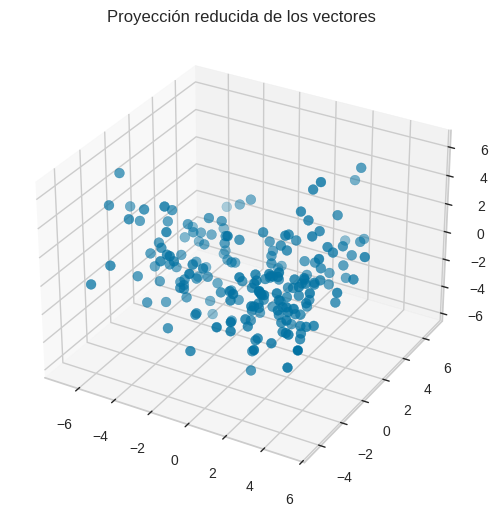

In [663]:
# Grafiquemos los componentes
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df_reduced.iloc[:,0], df_reduced.iloc[:,1], df_reduced.iloc[:,2], s=50)
ax.set_title("Proyección reducida de los vectores")
plt.show()

## Clusterización

Ahora apliquemos clusterización para entender que grupos de clientes se forman. Primero identifiquemos el número óptimo de grupos para que KMeans empleando **el método del codo**.

El número óptimo de clusters es: 4


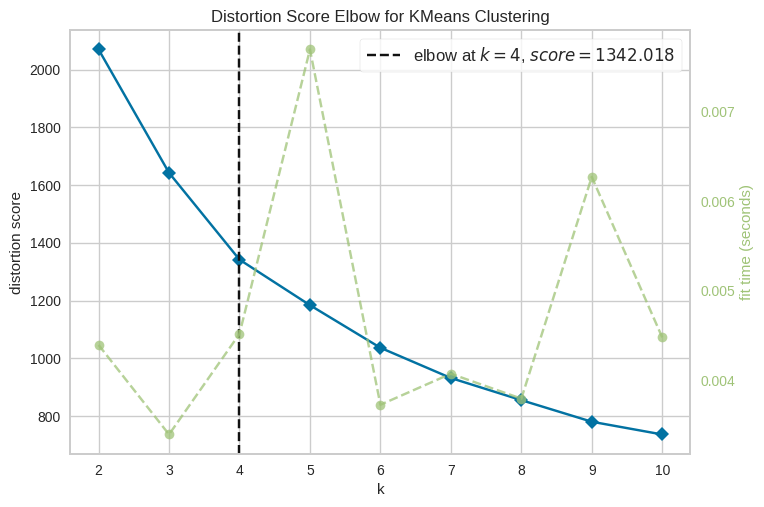

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [664]:
elbow = KElbowVisualizer(KMeans(random_state=42), k=10)
elbow.fit(df_reduced)
best_k = elbow.elbow_value_
print(f"El número óptimo de clusters es: {best_k}")
elbow.show()

In [665]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(df_reduced)
df_reduced["Cluster"] = clusters
df_reduced.index = df_features.index
df_reduced

,component 1,component 2,component 3,Cluster
Customer ID,,,,
CUST_0001,-5.824967,-4.384561,0.196454,1
CUST_0002,0.541058,0.858729,-0.576179,0
CUST_0003,1.621724,0.661432,-0.728904,0
CUST_0004,-1.584824,0.884021,-2.337811,3
CUST_0005,-2.420934,1.009923,-2.229389,3
...,...,...,...,...
CUST_0196,-2.050314,-0.421581,-0.613774,1
CUST_0197,-0.128631,1.934933,0.985849,2
CUST_0198,2.060602,-2.426961,1.150613,0


In [666]:
# Escogiendo una paleta de colores uniforme para el resto del análisis
viridis = plt.colormaps['viridis']
palette = [mcolors.to_hex(viridis(i / (best_k-1))) for i in range(best_k)]
print("Paleta de colores:", palette)

Paleta de colores: ['#440154', '#31688e', '#35b779', '#fde725']


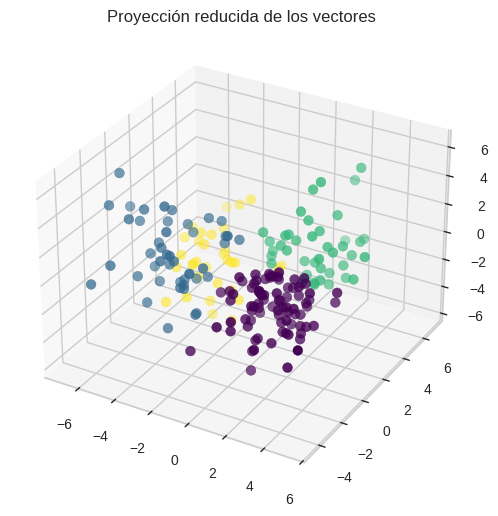

In [667]:
# Grafiquemos los componentes con los clusters
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df_reduced.iloc[:,0], df_reduced.iloc[:,1], df_reduced.iloc[:,2], s=50, c=df_reduced["Cluster"], cmap=viridis)
ax.set_title("Proyección reducida de los vectores")
plt.show()

## Evaluación

**Evaluación de la clusterización**

En esta sección evaluaremos el resultado del proceso de clusterización.

A diferencia de un problema de **clasificación supervisada**, en clustering **no contamos con una “verdad dura” (ground truth)** que nos permita calcular métricas tradicionales como accuracy, recall o F1-score. Esto significa que la evaluación de los resultados es en gran medida **cualitativa**, aunque podemos apoyarnos en métricas internas para obtener indicadores de la calidad de los clusters.

**📊 ¿Qué veremos en esta parte?**
1. **Métricas internas de clustering**
   - Usaremos funciones de `sklearn.metrics`:
     - `silhouette_score`: mide la cohesión (qué tan similares son los puntos dentro del mismo cluster) y la separación (qué tan distintos son los clusters entre sí).
     - `davies_bouldin_score`: evalúa la relación entre la dispersión intra-cluster y la separación inter-cluster (valores más bajos son mejores).
     - `calinski_harabasz_score`: compara la varianza entre clusters con la varianza dentro de los clusters (valores más altos indican mejores clusters).
   
2. **Distribución de los clusters**
   - Analizaremos el tamaño relativo de cada cluster para identificar posibles desbalances.

3. **Análisis cualitativo**
   - Observaremos las características predominantes de cada cluster para determinar si son **interpretables** y **útiles para negocio**.

Este análisis nos permitirá identificar fortalezas y posibles áreas de mejora en la segmentación, y será la base para la siguiente fase: **el perfilado de clusters**.


In [668]:
# Veamos las métricas de calidad internas
print(f"Silhouette Score: {silhouette_score(df_reduced, clusters)}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(df_reduced, clusters)}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(df_reduced, clusters)}")

Silhouette Score: 0.3574914157845517
Davies-Bouldin Score: 1.0912534548299573
Calinski-Harabasz Score: 114.18521310166987


**Interpretación de métricas internas de clusterización**

Hemos calculado tres métricas internas para evaluar la calidad de la clusterización obtenida. A continuación se presenta cada métrica junto con su interpretación:

---

**📐 Silhouette Score: 0.3574**
El *Silhouette Score* mide qué tan bien definidos están los clusters, considerando tanto la cohesión interna como la separación entre clusters.  
- 🔹 Valores cercanos a **1.0** indican que los puntos están bien agrupados y claramente separados de otros clusters.  
- 🔹 Valores cercanos a **0.0** indican clusters solapados.  
- 🔹 Valores negativos significarían puntos mal asignados.  

**Interpretación:** Un valor de **0.36** es **regular**, sugiere que algunos de los puntos no están bien ubicados dentro de sus clusters y que existe solapación entre algunos.

---

**🔥 Davies-Bouldin Score: 1.09125**
El *Davies-Bouldin Score* evalúa la relación entre la dispersión intra-cluster y la separación inter-cluster.  
- 🔹 **Valores más bajos son mejores** porque indican clusters compactos y bien separados.  
- 🔹 No tiene un rango fijo superior, pero valores **< 1** suelen considerarse aceptables.  

**Interpretación:** Un valor de **1.09** es **regular**, indicando que los clusters son relativamente compactos, pero que no están completamente bien diferenciados.

---

**📊 Calinski-Harabasz Score: 114.18**
El *Calinski-Harabasz Score* compara la varianza entre clusters con la varianza interna de los clusters.  
- 🔹 **Valores más altos son mejores**, ya que indican que los clusters son densos internamente y bien separados entre sí.  
- 🔹 No tiene un rango máximo, pero valores grandes suelen ser signo de buena segmentación.  

**Interpretación:** Un valor de **114.18** sugiere que los clusters presentan una estructura definida con separación relativa regular.

---

**✅ Conclusión general**
Las tres métricas apuntan a que la segmentación obtenida es **de regular calidad**: los clusters tienen una separación que puede ser difusa y hay indicios de que existe solapamiento. Esto brinda una base sólida para realizar el **análisis cualitativo y el perfilado de los clusters** en la siguiente etapa.


Cluster
0    0.415
1    0.220
2    0.205
3    0.160
Name: proportion, dtype: float64


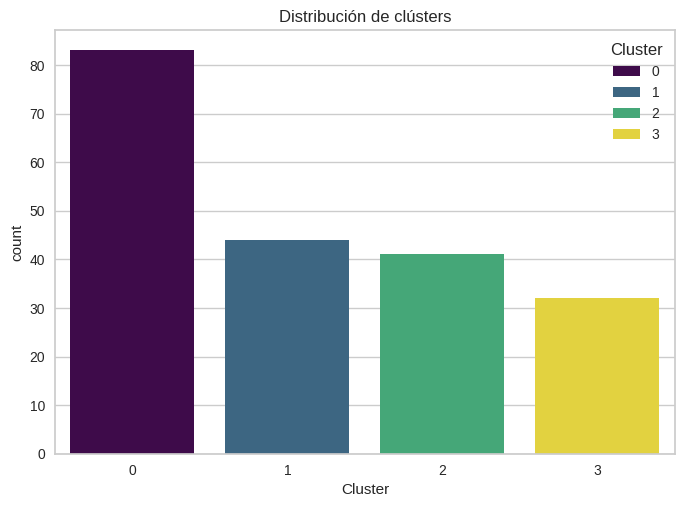

In [669]:
# Veamos la proporción de clústers
print(df_reduced["Cluster"].value_counts(normalize=True))
sns.countplot(x=df_reduced["Cluster"], hue=df_reduced["Cluster"], palette=palette)
plt.title("Distribución de clústers")
plt.show()

La distribución de clústers no es uniforme, típico de los patrones de data de la vida real en donde tenemos *grupos masivos* vs *grupos especiales*.

## Perfilamiento

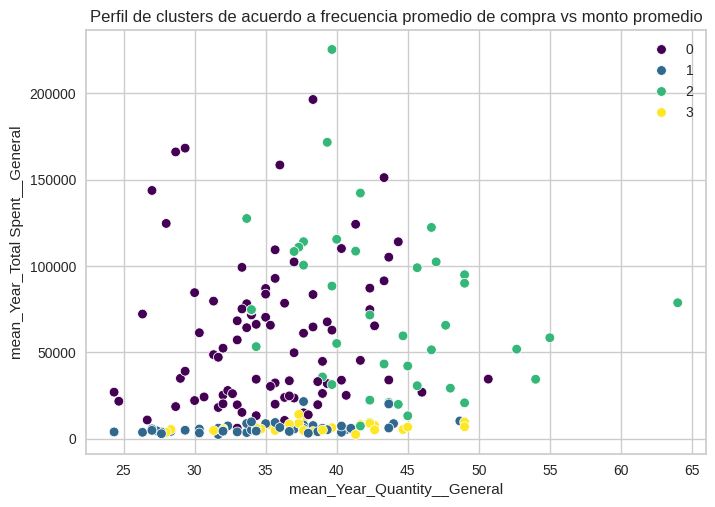

In [670]:
# Agreguemos la columna dataset al dataframe original
df_features["Cluster"] = clusters

# Analicemos la distribución de monto anual promedio vs frecuencia por cluster
sns.scatterplot(data = df_features,x=df_features["mean_Year_Quantity__General"],
                y=df_features["mean_Year_Total Spent__General"],hue=df_features["Cluster"], palette= palette)
plt.title("Perfil de clusters de acuerdo a frecuencia promedio de compra vs monto promedio")
plt.legend()
plt.show()

Vemos que claramente dos de los clústers (0 y 2) transaccionan montos promedios altos anual, mientras que (1 y 3) menos, a pesar de que los 4 grupos transaccionan en general con la misma frecuencia. Esto lo confirma la siguiente gráfica también.

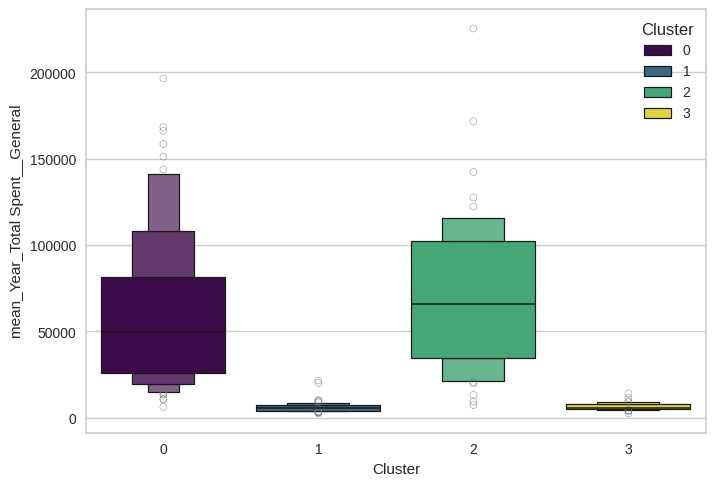

In [671]:
sns.boxenplot(x=df_features["Cluster"], y=df_features["mean_Year_Total Spent__General"],hue=df_features["Cluster"], palette=palette)
plt.show()

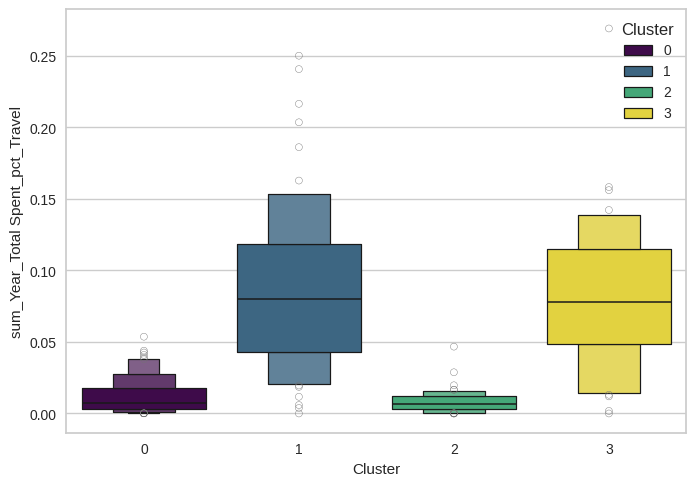

In [672]:
# Analicemos el comportamiento de los clústers por porcentaje de monto en gastos en viajes
sns.boxenplot(x=df_features["Cluster"], y=df_features["sum_Year_Total Spent_pct_Travel"],hue=df_reduced["Cluster"], palette=palette)
plt.show()

Como podemos ver en el caso de los clusters 1 y 3, tienen una distribución relevante en cuanto a proporción de consumos en gastos en viaje. Estos **gastan 5% y 15% de sus gastos en viaje**, a diferencia de los otros clusters que en promedio gastan 0%-1%.

A continuación veamos la distribución de los clientes por porcentaje de monto consumida en viajes vs. fitness.

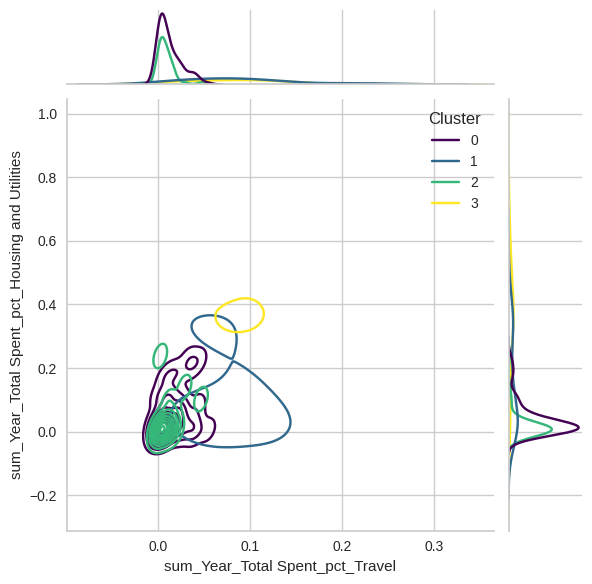

In [673]:
sns.jointplot(x=df_features["sum_Year_Total Spent_pct_Travel"], y=df_features["sum_Year_Total Spent_pct_Housing and Utilities"], hue =df_features["Cluster"], kind="kde", palette=palette)
plt.show()

Podemos ver que claramente el cluser 3 es diferente a los demás en ese aspecto, teniendo un **porcentaje de consumo en artículos de hogar de 30%-40%** a diferencia de los demás que promedian en  < 20% o disperso.

**Análisis de la variabilidad de medias entre clusters**

Después de agrupar los datos por cluster y calcular las medias de cada variable, queremos identificar **qué variables son más relevantes para diferenciar los clusters** para que se facilite el trabajo exploratorio del perfilamiento.

A diferencia de un análisis supervisado, aquí no tenemos una “variable objetivo” que nos indique la importancia de cada feature. Por eso, usamos un enfoque exploratorio:

---

**📌 ¿Qué haremos?**
1. **Calcular la variación de las medias de cada variable entre clusters**:  
   - **Varianza de las medias**: mide la dispersión de las medias entre clusters.  
   - **Desviación estándar de las medias**: alternativa intuitiva para ver la dispersión.  
   - **Rango (máximo - mínimo)**: diferencia entre el mayor y menor valor promedio de cada variable en los clusters.

2. **Ordenar las variables según estas métricas** para identificar cuáles muestran mayores diferencias.

3. **Visualizar los resultados** para entender rápidamente qué variables son potencialmente más útiles para describir y perfilar cada cluster.

---

**📊 ¿Por qué es útil?**

Este análisis permite:
- Descubrir **las variables que más contribuyen a separar los clusters**.
- Detectar variables que son **similares entre clusters** (menos relevantes para el perfilado).
- Priorizar las características al momento de hacer un **análisis cualitativo** o construir perfiles de clientes.


In [690]:
# Group by Cluster and calculate mean for each feature

df_scaled["Cluster"] = clusters

# Calcular medias
cluster_scaled_means = df_scaled.groupby("Cluster").mean(numeric_only=True).T
cluster_means = df_features.groupby("Cluster").mean(numeric_only=True).T

cluster_means.columns = [f"Avg. Cluster {col}" for col in cluster_means.columns]
cluster_means["Varianza"] = cluster_scaled_means.var(axis=1)
cluster_means["Rango"] = (cluster_scaled_means.max(axis=1) - cluster_scaled_means.min(axis=1)).abs()
cluster_means["Desv. Estándar"] = cluster_scaled_means.std(axis=1)

cluster_means = cluster_means.sort_values(by="Varianza", ascending=False)
cluster_means

,Avg. Cluster 0,Avg. Cluster 1,Avg. Cluster 2,Avg. Cluster 3,Varianza,Rango,Desv. Estándar
sum_Year_Total Spent_pct_Shopping,0.882705,0.233575,0.899095,0.148165,1.252214,2.071160,1.119024
sum_Year_Total Spent_pct_Housing and Utilities,0.038295,0.152027,0.022741,0.342502,0.883219,2.037804,0.939797
sum_Year_Total Spent_pct_Friend Activities,0.005895,0.057999,0.006286,0.032965,0.707423,1.757593,0.841085
sum_Year_Total Spent_pct_Travel,0.012569,0.088663,0.008424,0.083558,0.693359,1.527583,0.832682
sum_Year_Total Spent_pct_Fitness,0.014263,0.131952,0.012090,0.064022,0.667235,1.739662,0.816845
...,...,...,...,...,...,...,...
mean_Year_Total Spent__Travel,467.042088,489.942652,440.913577,494.908437,0.005495,0.161968,0.074126
mean_Year_Total Spent_pct_In-store,0.334448,0.298419,0.301122,0.287343,0.004668,0.158493,0.068319
mean_Year_Total Spent_pct_Digital Wallet,0.304521,0.287053,0.320968,0.276866,0.004140,0.145895,0.064341
sum_Year_Quantity__Travel,3.674699,3.863636,3.804878,3.812500,0.001569,0.092973,0.039611


**📊 Hallazgos: Variables discriminativas entre clusters**

Hemos calculado la **varianza de las medias** por cluster para identificar las variables que presentan las mayores diferencias entre grupos. Esto nos permite reconocer **qué características son más relevantes para diferenciar los segmentos** y, por tanto, son clave para el perfilado.

---

**🔥 Principales hallazgos**

1. **Gastos en "Shopping" como diferenciador clave**
   - 🥇 La variable `sum_Year_Total Spent_pct_Shopping` presenta la mayor varianza entre clusters.
   - Esto indica que el porcentaje del gasto anual destinado a compras es uno de los factores que más separa los grupos, sugiriendo diferencias claras en hábitos de consumo orientados al retail.

2. **"Housing and Utilities" también marca diferencias**
   - 🥈 `sum_Year_Total Spent_pct_Housing and Utilities` ocupa el segundo lugar en varianza.
   - Esto refleja diferencias en el porcentaje de gasto destinado a vivienda y servicios básicos, lo cual puede indicar distintos niveles de prioridades o estilos de vida.

3. **Ocio y actividades sociales son relevantes**
   - 🥉 Variables como `sum_Year_Total Spent_pct_Friend Activities` y `sum_Year_Total Spent_pct_Travel` también muestran una varianza significativa.
   - Esto apunta a diferencias entre clusters en cuanto a actividades recreativas y viajes, posibles indicadores de distintos perfiles sociodemográficos o intereses.

4. **Gasto en fitness y bienestar**
   - La variable `sum_Year_Total Spent_pct_Fitness` aparece también con una varianza notable.
   - Sugiere que ciertos clusters dedican más recursos a actividades relacionadas con la salud y el bienestar.

5. **Variables con baja discriminación**
   - Al final del ranking encontramos variables como:
     - `mean_Year_Total Spent_pct_In-store`
     - `mean_Year_Total Spent_pct_Digital Wallet`
     - `mean_Year_Quantity__Travel`
   - Estas variables tienen una **varianza muy baja**, indicando que los clusters son similares en estos aspectos y que no aportan mucho valor para el perfilado.

---

**📌 Conclusión**
Las variables con mayor varianza son las que mejor permiten **diferenciar y caracterizar los clusters**. En especial, el análisis sugiere que los hábitos de gasto en categorías como **shopping, vivienda, actividades sociales y fitness** son esenciales para construir perfiles ricos y accionables.

En cambio, variables con baja varianza pueden ser relegadas o recibir menor peso en el análisis cualitativo posterior.


Veamos por último las distribuciones del top 12 variables diferenciadoras para crear el perfil final.

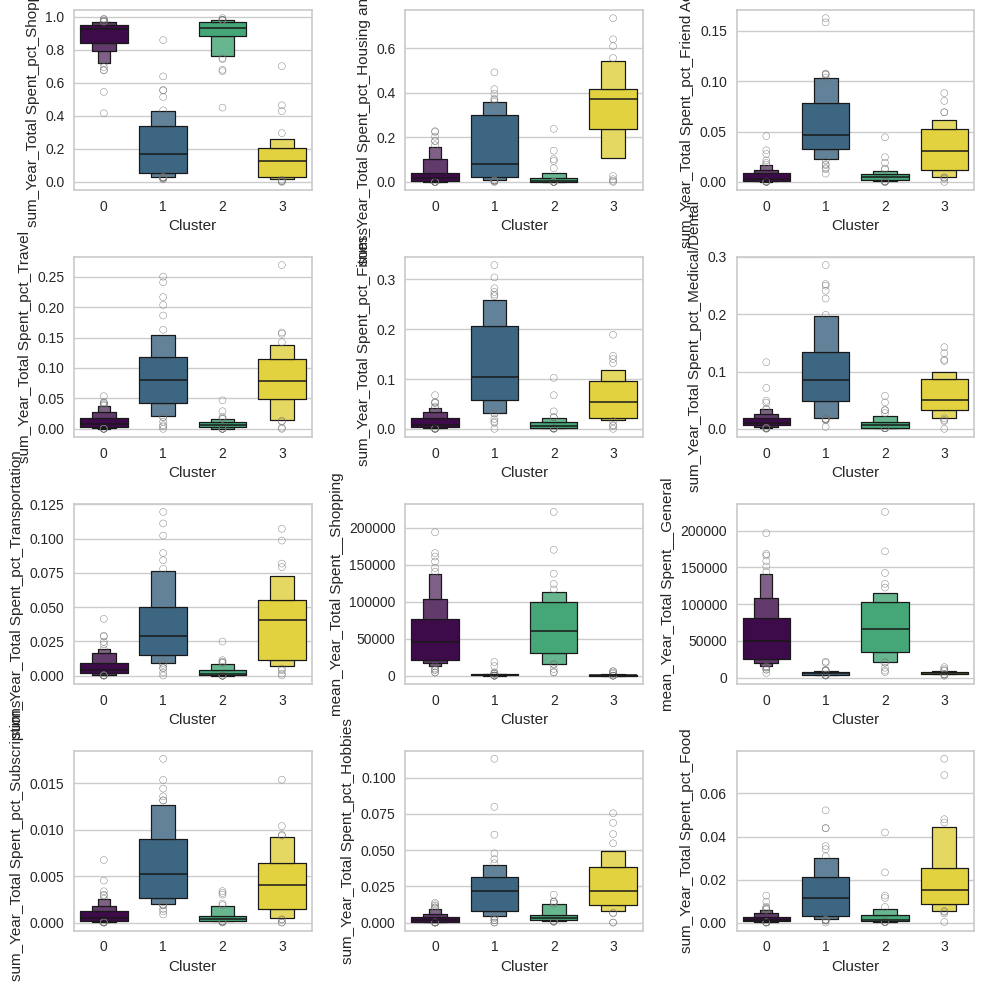

In [675]:
top_n = 12
best_features = cluster_means[:top_n].index

n_cols = 3

n_rows = (top_n + n_cols - 1) // n_cols  # compute needed rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,10))
axes = axes.flatten()  # flatten in case it's 2D

for i, feature in enumerate(best_features):
  sns.boxenplot(x=df_features["Cluster"], y=df_features[feature],hue=df_reduced["Cluster"], palette=palette, legend=False, ax=axes[i])

# Turn off any unused subplots
for j in range(top_n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Ahora obtengamos algunos KPIs cuantitativos y relativos que nos permitan argumentar la descripción de los perfiles más fácilmente.

In [681]:
cluster_means["Avg. Global"] = df_features.mean(axis=0)
for cluster in df_features["Cluster"].sort_values().unique():
  cluster_means[f"Uplift Avg. Cluster {cluster}"] = cluster_means[f"Avg. Cluster {cluster}"] - cluster_means["Avg. Global"]
cluster_means

,Avg. Cluster 0,Avg. Cluster 1,Avg. Cluster 2,Avg. Cluster 3,Varianza,Rango,Desv. Estándar,Avg. Global,Uplift Avg. Cluster 0,Uplift Avg. Cluster 1,Uplift Avg. Cluster 2,Uplift Avg. Cluster 3
sum_Year_Total Spent_pct_Shopping,0.882705,0.233575,0.899095,0.148165,1.252214,2.071160,1.119024,0.625730,0.256975,-0.392155,0.273366,-0.477565
sum_Year_Total Spent_pct_Housing and Utilities,0.038295,0.152027,0.022741,0.342502,0.883219,2.037804,0.939797,0.108800,-0.070505,0.043227,-0.086060,0.233701
sum_Year_Total Spent_pct_Friend Activities,0.005895,0.057999,0.006286,0.032965,0.707423,1.757593,0.841085,0.021769,-0.015874,0.036230,-0.015483,0.011195
sum_Year_Total Spent_pct_Travel,0.012569,0.088663,0.008424,0.083558,0.693359,1.527583,0.832682,0.039818,-0.027249,0.048845,-0.031395,0.043740
sum_Year_Total Spent_pct_Fitness,0.014263,0.131952,0.012090,0.064022,0.667235,1.739662,0.816845,0.047671,-0.033407,0.084282,-0.035581,0.016351
...,...,...,...,...,...,...,...,...,...,...,...,...
mean_Year_Total Spent__Travel,467.042088,489.942652,440.913577,494.908437,0.005495,0.161968,0.074126,471.182483,-4.140395,18.760168,-30.268906,23.725954
mean_Year_Total Spent_pct_In-store,0.334448,0.298419,0.301122,0.287343,0.004668,0.158493,0.068319,0.312153,0.022295,-0.013734,-0.011031,-0.024810
mean_Year_Total Spent_pct_Digital Wallet,0.304521,0.287053,0.320968,0.276866,0.004140,0.145895,0.064341,0.299625,0.004896,-0.012571,0.021343,-0.022758
sum_Year_Quantity__Travel,3.674699,3.863636,3.804878,3.812500,0.001569,0.092973,0.039611,3.765000,-0.090301,0.098636,0.039878,0.047500


**📌 Descripción de los clusters**

A continuación, se presentan los perfiles cualitativos de cada cluster identificados a partir del análisis de las medias y las variables más discriminativas, además de un nombre sugerido.

---

**🟢 Cluster 0: Jóvenes consumistas**
- 💳 **Alto consumos en shopping**: presenta los montos anuales de consumo más altos, especialmente en shopping el cual representa el 80% de sus gastos anuales.
- 🏠 **Dependiente y no enfocado al hogar**: muy baja proporción de sus gastos destinadas a artículos del hogar o comida del hogar, un -7% menor que el cliente promedio, lo cual puede ser indicativo de que es dependiente.
- 👥 Perfil más joven e impulsivo. Ideal para propuestas agresivas y oportunistas en shopping.

---

**🟣 Cluster 1: Entusiastas del bienestar**
- 🏃‍♀️ **Foco en bienestar y fitness**: se distingue por un mayor gasto en actividades relacionadas con salud y bienestar físico, consumiendo hasta más de 10 veces que el cliente típico. Además gasta más en medicinas (suplementos) que los demás.
- ⚖️ **Consumos moderados**: no muestra extremos de montos de consumos como el cluster 0 y 2.
- 💼 **Viajes y entretenimiento**: consume más en viajes que los demás clústers, esto representando un 8% de sus gastos anuales.
- 🌱 Potencial para ofrecerle propuestas conscientes y de calidad en productos para viajes y salud.

---

**🔵 Cluster 2: El power buyer**
- 🛍️ **Alto gasto en shopping**: destaca por una proporción significativamente mayor de su presupuesto destinada a compras. Un 90%, el mayor de todos los clusters.
- 🎁 **Mayor inversión en hobbies y regalos**: diferenciador clave frente al Cluster 0, este grupo gasta considerablemente más en ocio y consumo emocional.  
- 🌎 **Altos gastos en general**: este es un cliente de mayor nivel de ingresos que los demás clústers, ya que es el que tiene en promedio mayor monto anual en general.  

---

**🟡 Cluster 3: Padres de familia**
- 🏠 **Enfocado en el hogar**: aquí se encuentran los clientes que más gastan al año en artículos del hogar y comida. Esto es indicativo de que son posiblemente cabezas de familia o adultos estables.
- 🏃‍♀️ **Gasto en responsabilidades**: también se distingue por un mayor gasto en transporte en promedio, y el menor gasto en shopping de todos, representando solo un 15% en promedio anual.
- 📉 **Gasto moderado en categorías discrecionales**: mantiene un perfil conservador en hobbies y regalos, similar al Cluster 0, pero con mayor enfoque en el autocuidado.

---

**✅ Resumen**
Cada cluster refleja **estilos de vida y prioridades financieras distintas**:  
- 🟢 Cluster 0: Joven y compulsivo.
- 🟣 Cluster 1: Orientado al bienestar y la salud.
- 🔵 Cluster 2: Consumidor emocional con poder.
- 🟡 Cluster 3: Conservador, enfocado en necesidades básicas.
